# End-to-End Time Series Forecasting Project with TBATS and Pandas in Python

TBATS is a very powerful and flexible time series modelling method. It allows for multiple seasonalities and data with non-constant variance (heteroscedastic). A theoretical treatment of the model is given here, and this article focuses on its implementation in a larger project. In python, this powerful technique can be implemented in just a few lines of code. The following exercise was given as an interview question to me, and it is an interesting problem due to the anomalies and complexity of the data.

**The Data**

The Data
The Austin MetroBike dataset contains every bike trip in the Austin MetroBike system from 2014 until the present. In this exercise, we will use 2014–2020 to train the model and predict 2021 values, which can be compared with the published data for 2021 to validate the model.

**Required Packages**
- Pandas
- numpy
- matplotlib
- TBATS


-



**Data Preparation**

After we have downloaded Austin_MetroBike_Trips.csv, we import it using pandas.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tbats import TBATS

The dates need to be converted from strings to datetime objects to be useful. The following code converts the checkout dates to datetimes and then adds the checkout time to them to get a datetime object.

In [3]:
df = pd.read_csv('Austin_MetroBike_Trips.csv')

C:\Users\TURBULENCE\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.head()

,Trip ID,Membership Type,Bicycle ID,Bike Type,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
0,9900285854,Annual (San Antonio B-cycle),207.0,NaN,10/26/2014,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76,10.0,2014.0
1,9900285855,24-Hour Kiosk (Austin B-cycle),969.0,NaN,10/26/2014,13:12:00,2498.0,Convention Center / 4th St. @ MetroRail,2566.0,Pfluger Bridge @ W 2nd Street,58,10.0,2014.0
2,9900285856,Annual Membership (Austin B-cycle),214.0,NaN,10/26/2014,13:12:00,2537.0,West & 6th St.,2496.0,8th & Congress,8,10.0,2014.0
3,9900285857,24-Hour Kiosk (Austin B-cycle),745.0,NaN,10/26/2014,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,NaN,Zilker Park at Barton Springs & William Barton...,28,10.0,2014.0
4,9900285858,24-Hour Kiosk (Austin B-cycle),164.0,NaN,10/26/2014,13:12:00,2538.0,Bullock Museum @ Congress & MLK,NaN,Convention Center/ 3rd & Trinity,15,10.0,2014.0


In [5]:
df.info

<bound method DataFrame.info of             Trip ID                     Membership Type Bicycle ID  Bike Type  \
0        9900285854        Annual (San Antonio B-cycle)      207.0        NaN   
1        9900285855      24-Hour Kiosk (Austin B-cycle)      969.0        NaN   
2        9900285856  Annual Membership (Austin B-cycle)      214.0        NaN   
3        9900285857      24-Hour Kiosk (Austin B-cycle)      745.0        NaN   
4        9900285858      24-Hour Kiosk (Austin B-cycle)      164.0        NaN   
...             ...                                 ...        ...        ...   
1424781    24702889                     3-Day Weekender      19199        NaN   
1424782    24712544                             Local31      19645        NaN   
1424783    24717888                24 Hour Walk Up Pass      21630        NaN   
1424784    24504080                             Local31      19090        NaN   
1424785    24679122                             Local31      21772        NaN

In [6]:
df['start_dt'] = pd.to_datetime(df['Checkout Date']) + pd.to_timedelta(df['Checkout Time'])

To make the data useful, converting it from a list of points to a frequency per time period is necessary. I chose monthly frequency here, but weekly frequency can work too.

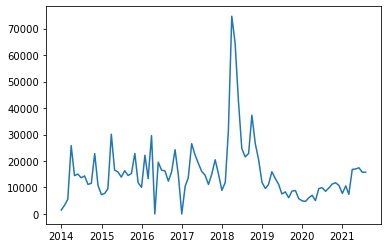

In [7]:
df = df.sort_values('start_dt').set_index('start_dt')
monthly_freq = df.resample('m').size()
plt.plot(monthly_freq)

This visualization informs us of a few characteristics of this data


* Seasonality — Bike trips peak at certain types of the year and dip at others, and this pattern is repeated every year. This is intuitive given changes in weather over the year.
* Heteroscedasticity— There are ways to test for heteroscedasticity, but the massive spike in rides compared to the rest of the data in 2018 and the relatively constant year of 2020 inform us of this visually. This limits the range of models we can use
* Anomalies — During 2016 and 2017, we see a month of zero rides. We can assume that this is not due to every cyclist giving up bike riding in those months, and rather due to a data anomaly. We will interpolate over those points to improve the accuracy of our forecast


The following lines fill weeks of 0 ridership with NaNs, and interpolate them using the surrounding weeks

In [8]:
monthly_freq[monthly_freq == 0] = np.nan
monthly_freq = monthly_freq.interpolate()

**Seasonality**

We should expect roughly a 1 year seasonality in biking due to changes in the seasons. We can confirm this via the autocorrelation function.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

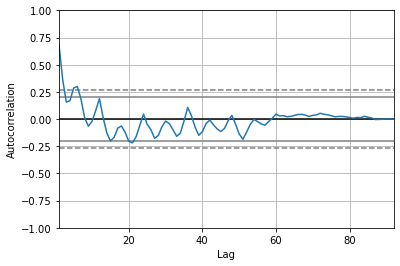

In [9]:
pd.plotting.autocorrelation_plot(monthly_freq)

The spike at 12 months confirms this. What this plot is showing is that ridership will correlate with ridership 12 months ahead of it — since our data is in monthly frequency, this is a year.

**Forecasting with TBATS**

The last step was done since we need to know the seasonality of the data for TBATS to work. The following code creates our estimator object.
estimator = TBATS(seasonal_periods=[12])

In [10]:
estimator = TBATS(seasonal_periods=[12])

We want to create a training set to forecast from, using data from 2014–2020.

In [11]:
train_set = monthly_freq[:'2020-12-31']

The following code fits our TBATS model to our data.

In [12]:
fitted_model = estimator.fit(train_set)

Now we can forecast 1 year (12 periods) ahead

In [13]:
y_forecasted = fitted_model.forecast(steps=12)

We want to attach dates to these forecasts for easier plotting. pd.date_range creates a range of dates from a start date, number of periods, and a frequency.

In [18]:
monthly_index = pd.date_range(
            pd.to_datetime('2021-01-01'),
            periods=12,
            freq='m')
forecasted_data = pd.DataFrame(
            y_forecasted,
            index=monthly_index)

**Results and Analysis**

Plotting our forecast against the ridership data for 2021 is done in matplotlib

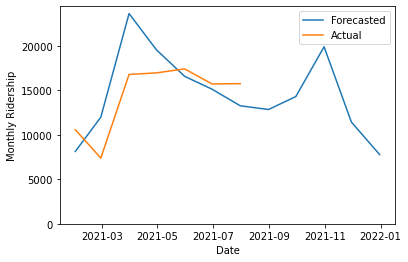

In [15]:
plt.plot(forecasted_data, label='Forecasted')
plt.plot(monthly_freq['2021-01-01':], label='Actual')
plt.xlabel('Date')
plt.ylabel('Monthly Ridership')
plt.ylim(bottom=0)
plt.legend()

There are a range of metrics for quantifying time series error. In this example, I will use Mean Absolute Percentage Error (MAPE) since percentage errors eliminate the scale of the data. This can be done since the data is always positive, but in cases where the data can be 0, this metric cannot be used due to potential division by zero errors. In that case, Root Mean Squared Error (RMSE) or similar metrics can be used. Since there are only 7 data points from 2021 published so far, we will take the first 7 months of 2021’s forecasted data for this metric.

In [19]:
y_true = np.array(monthly_freq['2021-01-01':].to_numpy())
y_pred = y_forecasted[:7]
MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE: {MAPE}%")

MAPE: 23.668170602385217%


Gives a MAPE of 23.6%. This number can then be used to compare the efficacy of this approach vs other types of suitable time series models such as GARCH.